In [1]:
from core.TrajectoryDF import NumPandasTraj as TrajDF
from features.spatial_features import SpatialFeatures as spatial
from features.temporal_features import TemporalFeatures as temporal
import matplotlib.pyplot as plt
from preprocessing.interpolation import Interpolation as ip
from preprocessing.filters import Filters as filt
from utilities.conversions import Conversions as con
from preprocessing.helpers import Helpers as help

import utilities.constants as const
import pandas as pd
import folium as fol
from scipy.interpolate import CubicSpline, interp2d
import numpy as np

In [2]:
%%time

# atlantic = pd.read_csv('./data/atlantic.csv')
# atlantic = con.convert_directions_to_degree_lat_lon(atlantic, 'Latitude',"Longitude")
# def convert_to_datetime(row):
#         this_date = '{}-{}-{}'.format(str(row['Date'])[0:4], str(row['Date'])[4:6], str(row['Date'])[6:])
#         this_time = '{:02d}:{:02d}:00'.format(int(row['Time']/100), int(str(row['Time'])[-2:]))
#         return '{} {}'.format(this_date, this_time)
# atlantic['DateTime'] = atlantic.apply(convert_to_datetime, axis=1)
# sample = TrajDF(atlantic,
#                 latitude='Latitude',
#                 longitude='Longitude',
#                 datetime='DateTime',
#                 traj_id='ID',
#                 rest_of_columns=[])
gulls = pd.read_csv('./data/gulls.csv')
sample = TrajDF(gulls,
                latitude='location-lat',
                longitude='location-long',
                datetime='timestamp',
                traj_id='tag-local-identifier',
                rest_of_columns=[])
# rf = pd.read_csv('./data/geolife_sample.csv')
# sample = TrajDF(rf, 'lat', 'lon', 'datetime', 'id')

CPU times: user 278 ms, sys: 15.9 ms, total: 294 ms
Wall time: 295 ms


In [3]:
small = sample.reset_index().loc[sample.reset_index()[const.TRAJECTORY_ID] == '91732'][[const.TRAJECTORY_ID, const.DateTime, const.LAT, const.LONG]]
a = small.reset_index()[const.DateTime].diff().dt.total_seconds()
print((a > 3600*4).value_counts())


True     1501
False     469
Name: DateTime, dtype: int64


In [4]:
%%time

small_ip_rw = help._random_walk_help(small.reset_index(drop=True).set_index([const.DateTime]), '91732', 3600*4)
print(f"Original Length: {len(small)}")
print(f"Interpolated Length: {len(small_ip_rw)}")


Original Length: 1970
Interpolated Length: 3471
CPU times: user 4.58 s, sys: 0 ns, total: 4.58 s
Wall time: 4.59 s


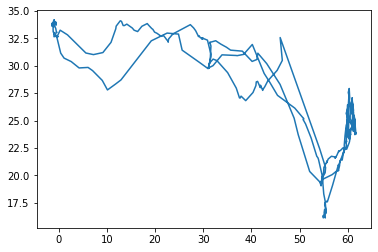

In [5]:
plt.plot(small[const.LAT], small[const.LONG])

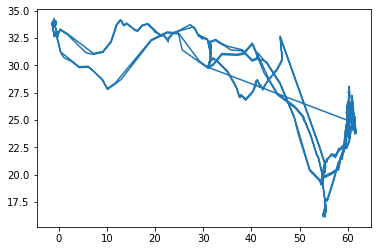

In [6]:
plt.plot(small_ip_rw[const.LAT], small_ip_rw[const.LONG])

In [7]:
%%time

ip_rw = ip.interpolate_position(sample,
                                3600*4,
                                'random-walk')
print(f"Original Length: {len(sample)}")
print(f"Interpolated Length: {len(ip_rw)}")


Original Length: 89869
Interpolated Length: 157775
CPU times: user 248 ms, sys: 105 ms, total: 352 ms
Wall time: 47.2 s


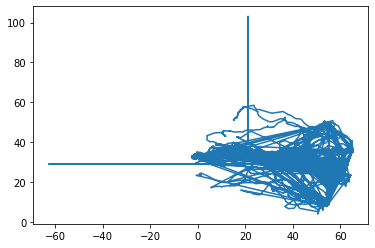

In [8]:
plt.plot(sample[const.LAT], sample[const.LONG])


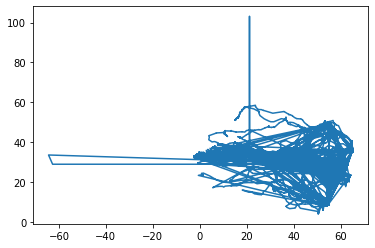

In [9]:
plt.plot(ip_rw[const.LAT], ip_rw[const.LONG])

In [10]:
b = sample.reset_index()[const.DateTime].diff().dt.total_seconds()
print((b > 3600*4).value_counts())

True     67910
False    21959
Name: DateTime, dtype: int64


In [11]:
small_ip_kin = help._kinematic_help(small.reset_index(drop=True).set_index([const.DateTime]), '91732', 3600*4)
print(f"Original Length: {len(small)}")
print(f"Interpolated Length: {len(small_ip_kin)}")
small_ip_kin.sort_values(const.DateTime).head(10)

Original Length: 1970
Interpolated Length: 3470


,traj_id,lat,lon
DateTime,,,
2009-05-27 14:00:00,91732,61.247830,24.586170
2009-05-27 20:00:00,91732,61.232670,24.582170
2009-05-28 00:00:00,91732,61.232670,24.582170
2009-05-28 05:00:00,91732,61.188330,24.531330
2009-05-28 08:00:00,91732,61.232830,24.582000
2009-05-28 12:00:00,91732,61.232831,24.582001
2009-05-28 14:00:00,91732,61.232670,24.582500
2009-05-28 18:00:00,91732,61.232670,24.582500
2009-05-28 20:00:00,91732,61.247670,24.586170


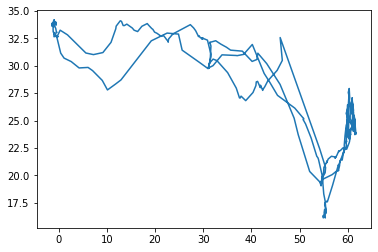

In [12]:
plt.plot(small[const.LAT], small[const.LONG])

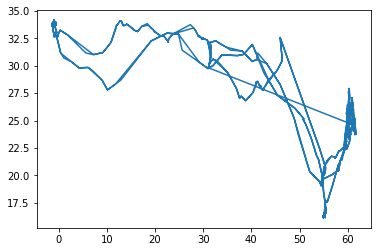

In [13]:
plt.plot(small_ip_kin[const.LAT], small_ip_kin[const.LONG])

In [14]:
ip_kin = ip.interpolate_position(sample,
                                3600*4,
                                'kinematic')
print(f"Original Length: {len(sample)}")
print(f"Interpolated Length: {len(ip_kin)}")

Original Length: 89869
Interpolated Length: 157670


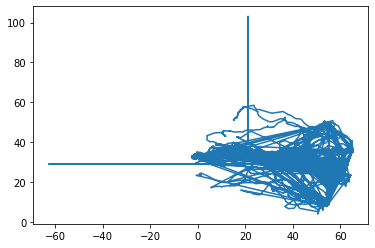

In [15]:
plt.plot(sample[const.LAT], sample[const.LONG])

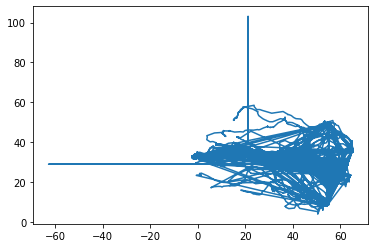

In [16]:
plt.plot(ip_kin[const.LAT], ip_kin[const.LONG])

In [17]:
ip_kin.head(10)


lat        lon
traj_id DateTime                                 
91732   2009-05-27 14:00:00  61.247830  24.586170
        2009-05-27 20:00:00  61.232670  24.582170
        2009-05-28 00:00:00  61.232670  24.582170
        2009-05-28 05:00:00  61.188330  24.531330
        2009-05-28 08:00:00  61.232830  24.582000
        2009-05-28 12:00:00  61.232831  24.582001
        2009-05-28 14:00:00  61.232670  24.582500
        2009-05-28 18:00:00  61.232670  24.582500
        2009-05-28 20:00:00  61.247670  24.586170
        2009-05-29 00:00:00  61.247670  24.586170

In [18]:
lats = small[const.LAT].values
lons = small[const.LONG].values

loc = []
for i in range(len(lats)):
    loc.append((lats[i], lons[i]))

m1 = fol.Map(location=[lats[0], lons[0]], zoom_start=11)

fol.PolyLine(loc,
             color='blue',
             weight=1,
             opacity=0.8).add_to(m1)
m1

In [19]:
lats = small_ip_kin[const.LAT].values
lons = small_ip_kin[const.LONG].values

loc = []
for i in range(len(lats)):
    loc.append((lats[i], lons[i]))

m2 = fol.Map(location=[lats[0], lons[0]], zoom_start=11)

fol.PolyLine(loc,
             color='blue',
             weight=1,
             opacity=0.8).add_to(m2)
m2

In [20]:
lats = small_ip_rw[const.LAT].values
lons = small_ip_rw[const.LONG].values

loc = []
for i in range(len(lats)):
    loc.append((lats[i], lons[i]))

m3 = fol.Map(location=[lats[0], lons[0]], zoom_start=11)

fol.PolyLine(loc,
             color='blue',
             weight=1,
             opacity=0.8).add_to(m3)
m3